100%|██████████| 170498071/170498071 [00:01<00:00, 104593916.67it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


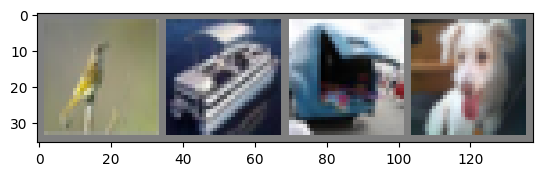

 bird  ship truck   dog


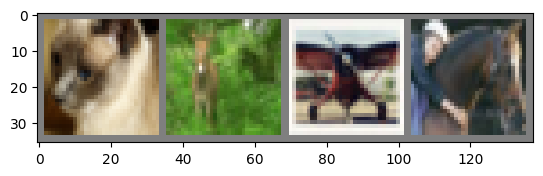

  cat  deer airplane horse


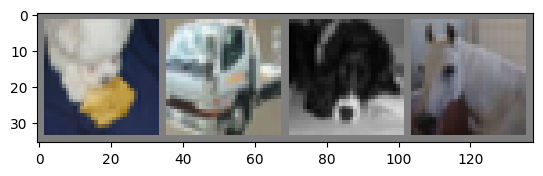

  dog truck   dog horse


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    img = np.clip(img, 0, 1)  # Clip to ensure pixel values are between 0 and 1
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Defining transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image tensors
])

# Downloading and loading the training dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Creating a data loader for the training dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

# Downloading and loading the test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Creating a data loader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

# The CIFAR-10 classes
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_batches_displayed = 0

# Getting some random training images
for images, labels in train_loader:

    # Showing images
    imshow(torchvision.utils.make_grid(images))

    # Printing labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
    num_batches_displayed = num_batches_displayed + 1

    if(num_batches_displayed == 3) :
      break
    else:
      continue

<h1>Feature Extraction : HoG

In [3]:
# HoG features capture the shape and edge information.

import torch.nn as nn
import torchvision.models as models
from skimage.feature import hog
from skimage import exposure
from skimage.io import imread
from skimage.transform import resize

# Function to compute HoG features
def compute_hog(img):
    # Resizing image
    resized_img = resize(img, (128*4, 64*4))
    # Creating HoG features
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    return fd

# Initializing a list to store HoG features
hog_features_list = []

# Example Usage
num_iterated_hog = 0

# Iterating through each batch of images and labels in the training loader
for images, _ in train_loader:
    num_iterated_hog = num_iterated_hog + 1

    # Iterating through each image in the batch
    for img in images:
        # Computing HoG features for the image
        hog_features = compute_hog(img)
        # Appending the computed HoG features to the list
        hog_features_list.append(hog_features)

    # Breaking the loop after meeting requirements
    if(num_iterated_hog == 3):
      break
    else :
      continue

# Converting the list of HoG features to a numpy array
hog_features_array = np.stack(hog_features_list)

print("Shape of HoG features:", hog_features_array.shape)
print(hog_features_array)

# Saving the extracted HoG features
torch.save(hog_features_array, 'hog_features.pt')

Shape of HoG features: (12, 70308)
[[0.35340402 0.         0.         ... 0.         0.         0.40043327]
 [0.42772704 0.         0.         ... 0.         0.         0.36523864]
 [0.35329676 0.         0.         ... 0.         0.         0.35352802]
 ...
 [0.40824252 0.         0.         ... 0.         0.         0.35339233]
 [0.32289565 0.0595101  0.         ... 0.         0.         0.35711673]
 [0.41282865 0.         0.         ... 0.         0.         0.35353842]]


<h1>Feature Extraction : CNN

In [4]:
# CNN features capture higher-level visual semantics.

import torch.nn as nn
import torchvision.models as models
from PIL import Image

# Loading pre-trained ResNet-50 model
resnet = models.resnet50(pretrained=True)

# Removing the last fully connected layer
resnet = nn.Sequential(*list(resnet.children())[:-1])

# Setting the model to evaluation mode
resnet.eval()

# Function to extract features from an image
def extract_features(image, model):
    # Preprocessing the image
    preprocess = transforms.Compose([
        transforms.ToPILImage(),  # Convert tensor to PIL Image
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image)
    # Adding batch dimension
    image = image.unsqueeze(0)
    # Extracting features
    with torch.no_grad():
        features = model(image)
    # Removing the batch dimension
    features = features.squeeze(0)
    return features

# Initializing a list to store CNN features
cnn_features_list = []

# Example Usage
num_iterated_cnn = 0

# Iterating through each image in the CIFAR-10 training dataset
for images, _ in train_loader:
    num_iterated_cnn = num_iterated_cnn + 1

    for img in images:
        # Extracting CNN features for the image
        features = extract_features(img, resnet)
        # Appending the features to the list
        cnn_features_list.append(features)

    # Breaking the loop after meeting requirements
    if(num_iterated_cnn == 3) :
      break
    else :
      continue

# Converting the list of CNN features to a numpy array
cnn_features_array = torch.stack(cnn_features_list)

print("Shape of CNN features:", cnn_features_array.shape)
print(cnn_features_array)

# Saving the extracted CNN features
torch.save(cnn_features_array, 'cnn_features.pt')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 110MB/s]


Shape of CNN features: torch.Size([12, 2048, 1, 1])
tensor([[[[0.1474]],

         [[0.2477]],

         [[0.4104]],

         ...,

         [[0.2646]],

         [[0.1162]],

         [[0.0916]]],


        [[[0.1395]],

         [[0.1790]],

         [[0.0355]],

         ...,

         [[0.3914]],

         [[0.5221]],

         [[0.3649]]],


        [[[0.7469]],

         [[0.0620]],

         [[0.0976]],

         ...,

         [[0.6832]],

         [[0.2400]],

         [[0.8734]]],


        ...,


        [[[0.4913]],

         [[0.0712]],

         [[0.2059]],

         ...,

         [[0.5370]],

         [[0.2025]],

         [[0.6021]]],


        [[[0.1375]],

         [[0.5132]],

         [[0.2371]],

         ...,

         [[0.1368]],

         [[0.0978]],

         [[0.2111]]],


        [[[0.1641]],

         [[0.0663]],

         [[0.8444]],

         ...,

         [[0.1636]],

         [[0.1155]],

         [[0.6050]]]])


<h1>Feature Representation using Unified Representation

In [5]:
# Reshaping CNN features to match the number of features in HoG representation
cnn_features_array = cnn_features_array.view(cnn_features_array.shape[0], -1)

# Concatenating HoG and CNN features along the feature dimension
unified_features_array = np.concatenate((hog_features_array, cnn_features_array), axis=1)

print("Shape of unified features:", unified_features_array.shape)
print(unified_features_array)

# Saving the unified features
torch.save(unified_features_array, 'unified_features.pt')

Shape of unified features: (12, 72356)
[[0.35340402 0.         0.         ... 0.26457456 0.11623188 0.09163812]
 [0.42772704 0.         0.         ... 0.39143527 0.52213997 0.36489058]
 [0.35329676 0.         0.         ... 0.68317467 0.23997886 0.8733792 ]
 ...
 [0.40824252 0.         0.         ... 0.53698903 0.20251215 0.60213274]
 [0.32289565 0.0595101  0.         ... 0.13681994 0.0978137  0.2110708 ]
 [0.41282865 0.         0.         ... 0.16356036 0.1155412  0.6049888 ]]


<h1>Similarity Computation

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

# Computing cosine similarity matrix ( could also use euclidean distance , manhattan distance for this purpose)
cosine_sim_matrix = cosine_similarity(unified_features_array)

print("Cosine similarity matrix shape:", cosine_sim_matrix.shape)
print(cosine_sim_matrix)

Cosine similarity matrix shape: (12, 12)
[[1.000002   0.739889   0.7504028  0.7270917  0.7386063  0.7640622
  0.76129323 0.7254457  0.7574994  0.693759   0.64435685 0.7308245 ]
 [0.739889   1.0000042  0.74051136 0.71614146 0.7371696  0.70856565
  0.68693125 0.69458586 0.7241708  0.70078564 0.70234686 0.6619133 ]
 [0.7504028  0.74051136 1.0000049  0.69992757 0.7568973  0.747148
  0.75764495 0.760623   0.7658526  0.6878599  0.6557275  0.77065814]
 [0.7270917  0.71614146 0.69992757 1.0000023  0.73196346 0.67072475
  0.65361977 0.69746554 0.7560357  0.69712424 0.6692907  0.70982623]
 [0.7386063  0.7371696  0.7568973  0.73196346 1.0000033  0.71995157
  0.71045774 0.7641413  0.78581256 0.69252074 0.5998273  0.7732594 ]
 [0.7640622  0.70856565 0.747148   0.67072475 0.71995157 1.0000024
  0.681374   0.6880146  0.7382991  0.61063105 0.63603675 0.6497647 ]
 [0.76129323 0.68693125 0.75764495 0.65361977 0.71045774 0.681374
  1.000003   0.73567015 0.6794465  0.6703127  0.66325784 0.7153708 ]
 [0.72